<a href="https://colab.research.google.com/github/fatma-ds/sentiment_Analysis/blob/main/Restaurant_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Restaurant_Reviews(Sentiment Analysis)

### 1.Download the dataset that is about 25 KB 

In [ ]:
import pandas as pd
from sklearn import preprocessing
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
review_file_path = "/content/Restaurant_Reviews.tsv"
review_csv_ds = pd.read_csv(review_file_path,sep='\t')

review_csv_ds        

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0


In [ ]:

review_csv_ds.Liked.value_counts()

1    500
0    500
Name: Liked, dtype: int64

### Clean and preprocess the text data and split into training and test dataset.

### Separate Input Texts and Target Texts

In [ ]:
# Remove all special characters, punctuation and spaces
review_csv_ds['Review'] = review_csv_ds['Review'].apply(lambda x: re.sub(r'[^A-Za-z0-9]+',' ',x))
# Replace special characters,<br />,  in the file
review_csv_ds['Review'] = review_csv_ds['Review'].apply(lambda x: re.sub(r"<br />", " ", x))
# Remove length <=2
review_csv_ds['Review'] = review_csv_ds['Review'].apply(lambda x: re.sub(r'\b[a-zA-Z]{1,2}\b', '', x))
            



In [ ]:
X = review_csv_ds['Review'].values
y = review_csv_ds['Liked'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [ ]:
print(f'X_train size  ={X_train.shape}; X_test size  ={X_test.shape}')

X_train size  =(800,); X_test size  =(200,)


In [ ]:
# Specify the vocab size
VOCAB_SIZE = 1000
# Perform textvectorization
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)

# Fits the state of the preprocessing layer to the dataset.
encoder.adapt(X_train)

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'was', 'this', 'food', 'not', 'for',
       'place', 'good', 'service', 'that', 'very', 'great', 'are', 'with',
       'have', 'had', 'back'], dtype='<U17')

### Build a baseline RNN model using embedding layer and GRU on the training dataset and evaluate it on the test dataset.

## Create the RNN Model

In [ ]:
model = tf.keras.Sequential([
    # Convert review text to indices
    encoder, 
    #convert words to numerical values
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,# each word is mapped to a 64 dimensional vector
       # Mask the variable sequence lengths and ensure they have the same length by padding
        mask_zero=True),
    
    # passed the numerical value to a GRU unit 
    tf.keras.layers.GRU(256, return_sequences=True),
   
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256)),
   
    # Binary classifier since label has two classes of positive and negative 
    tf.keras.layers.Dense(64, activation='relu'),

    #the last layer must have one neuron since it is a binary classification 
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
%%time
history = model.fit(x=X_train,y=y_train,batch_size= 32,epochs=20,
          validation_data=(X_test,y_test), verbose= 1
)

Epoch 1/20
25/25 [==============================] - 11s 139ms/step - loss: 0.6925 - accuracy: 0.5000 - val_loss: 0.6921 - val_accuracy: 0.5000
Epoch 2/20
25/25 [==============================] - 1s 40ms/step - loss: 0.6894 - accuracy: 0.5000 - val_loss: 0.6897 - val_accuracy: 0.5000
Epoch 3/20
25/25 [==============================] - 1s 39ms/step - loss: 0.6833 - accuracy: 0.5000 - val_loss: 0.6825 - val_accuracy: 0.5000
Epoch 4/20
25/25 [==============================] - 1s 38ms/step - loss: 0.6636 - accuracy: 0.5000 - val_loss: 0.6561 - val_accuracy: 0.5000
Epoch 5/20
25/25 [==============================] - 1s 40ms/step - loss: 0.5883 - accuracy: 0.6100 - val_loss: 0.5808 - val_accuracy: 0.7050
Epoch 6/20
25/25 [==============================] - 1s 40ms/step - loss: 0.4247 - accuracy: 0.8100 - val_loss: 0.6031 - val_accuracy: 0.7150
Epoch 7/20
25/25 [==============================] - 1s 40ms/step - loss: 0.3290 - accuracy: 0.8662 - val_loss: 0.5954 - val_accuracy: 0.7100
Epoch 8/20


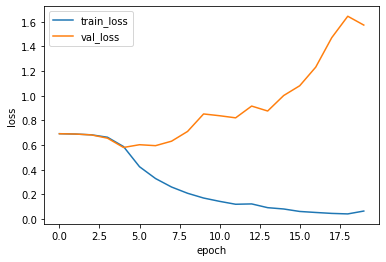

In [ ]:
## Evaluate the Model
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
# Plot train loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
# Plot validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
# Add legends
plt.legend(labels=['train_loss', 'val_loss'])

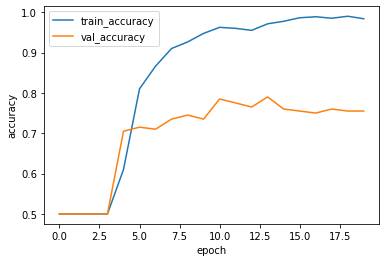

In [ ]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
# Plot validation loss
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
# Add legends
plt.legend(labels=['train_accuracy', 'val_accuracy'])

In [ ]:
y_pred = (model.predict(X_test)> 0.5).astype(int)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[70, 30],
       [19, 81]])

In [ ]:
from sklearn.metrics import classification_report
label_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names=label_names))

              precision    recall  f1-score   support

    negative       0.79      0.70      0.74       100
    positive       0.73      0.81      0.77       100

    accuracy                           0.76       200
   macro avg       0.76      0.76      0.75       200
weighted avg       0.76      0.76      0.75       200



### Build a second RNN model using embedding layer and LSTM and evaluate it on the test dataset.

In [ ]:
model = tf.keras.Sequential([
    # Convert review text to indices
    encoder, 
    #convert words to numerical values 
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,# each word is mapped to a 64 dimensional vector
        #Mask the variable sequence lengths and ensure they have the same length by padding
        mask_zero=True),
    # passed the numerical value to  a LSTM
    tf.keras.layers.LSTM(256, return_sequences=True),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
  
     
    # Binary classifier since the label has two classes of positive and negative
    tf.keras.layers.Dense(64, activation='relu'),
 
    #the last layer must have one neuron since it is a binary classification 
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
%%time
history = model.fit(x=X_train,y=y_train,batch_size= 32,epochs=20,
          validation_data=(X_test,y_test), verbose= 1
)

Epoch 1/20
25/25 [==============================] - 12s 181ms/step - loss: 0.6928 - accuracy: 0.5000 - val_loss: 0.6920 - val_accuracy: 0.5000
Epoch 2/20
25/25 [==============================] - 2s 79ms/step - loss: 0.6902 - accuracy: 0.5000 - val_loss: 0.6884 - val_accuracy: 0.5000
Epoch 3/20
25/25 [==============================] - 2s 80ms/step - loss: 0.6777 - accuracy: 0.5000 - val_loss: 0.6650 - val_accuracy: 0.5000
Epoch 4/20
25/25 [==============================] - 2s 85ms/step - loss: 0.6007 - accuracy: 0.5238 - val_loss: 0.6613 - val_accuracy: 0.5350
Epoch 5/20
25/25 [==============================] - 2s 98ms/step - loss: 0.5240 - accuracy: 0.6625 - val_loss: 0.6732 - val_accuracy: 0.5600
Epoch 6/20
25/25 [==============================] - 2s 96ms/step - loss: 0.4446 - accuracy: 0.7312 - val_loss: 0.7066 - val_accuracy: 0.6300
Epoch 7/20
25/25 [==============================] - 2s 89ms/step - loss: 0.3943 - accuracy: 0.7800 - val_loss: 0.6776 - val_accuracy: 0.6550
Epoch 8/20


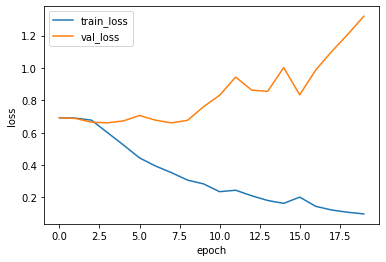

In [ ]:
## Evaluate the Model
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
# Plot train loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
# Plot validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
# Add legends
plt.legend(labels=['train_loss', 'val_loss'])

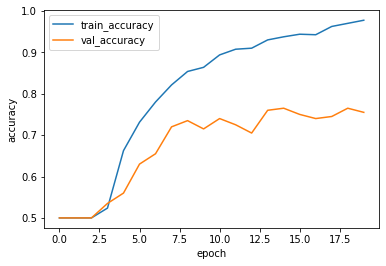

In [ ]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
# Plot validation loss
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
# Add legends
plt.legend(labels=['train_accuracy', 'val_accuracy'])

In [ ]:
y_pred = (model.predict(X_test)> 0.5).astype(int)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[70, 30],
       [19, 81]])

In [ ]:
from sklearn.metrics import classification_report
label_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names=label_names))

              precision    recall  f1-score   support

    negative       0.79      0.70      0.74       100
    positive       0.73      0.81      0.77       100

    accuracy                           0.76       200
   macro avg       0.76      0.76      0.75       200
weighted avg       0.76      0.76      0.75       200



### 5.Build a third RNN model using embedding layer and GRU and LSTM and evaluate it on the test dataset.

In [ ]:
model = tf.keras.Sequential([
    # Convert review text to indices
    encoder, 
    #convert words to numerical values that"understand" context
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,# each word is mapped to a 64 dimensional vector
       
        mask_zero=True),
    # passed the numerical value to a GRU unit 
    tf.keras.layers.GRU(256, return_sequences=True),
    #then pass it to a LSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
    #the output of the above codes is a numerical vectorof the review text
    #since the label has two classes of positive and negative 
    # Binary classifier
    tf.keras.layers.Dense(64, activation='relu'),
    # you may add more layer if you like 
    #the last layer must have one neuron since it is a binary classification 
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
%%time
history = model.fit(x=X_train,y=y_train,batch_size= 32,epochs=20,
          validation_data=(X_test,y_test), verbose= 1
)

Epoch 1/20
25/25 [==============================] - 12s 206ms/step - loss: 0.6928 - accuracy: 0.5000 - val_loss: 0.6920 - val_accuracy: 0.5000
Epoch 2/20
25/25 [==============================] - 2s 80ms/step - loss: 0.6909 - accuracy: 0.5000 - val_loss: 0.6894 - val_accuracy: 0.5000
Epoch 3/20
25/25 [==============================] - 2s 94ms/step - loss: 0.6832 - accuracy: 0.5000 - val_loss: 0.6760 - val_accuracy: 0.5000
Epoch 4/20
25/25 [==============================] - 2s 97ms/step - loss: 0.6327 - accuracy: 0.5238 - val_loss: 0.5890 - val_accuracy: 0.6150
Epoch 5/20
25/25 [==============================] - 3s 104ms/step - loss: 0.4944 - accuracy: 0.7400 - val_loss: 0.5768 - val_accuracy: 0.6900
Epoch 6/20
25/25 [==============================] - 2s 93ms/step - loss: 0.4185 - accuracy: 0.8150 - val_loss: 0.5673 - val_accuracy: 0.7150
Epoch 7/20
25/25 [==============================] - 2s 97ms/step - loss: 0.3592 - accuracy: 0.8425 - val_loss: 0.5966 - val_accuracy: 0.7150
Epoch 8/20

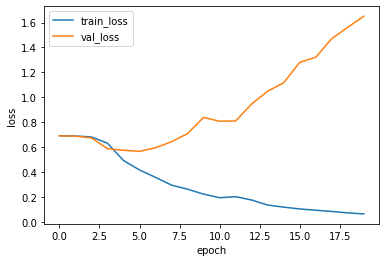

In [ ]:
## Evaluate the Model
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
# Plot train loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
# Plot validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
# Add legends
plt.legend(labels=['train_loss', 'val_loss'])

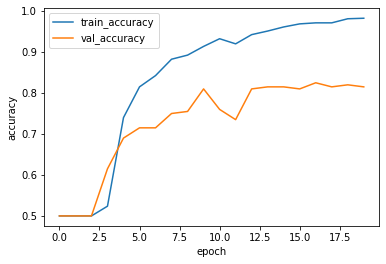

In [ ]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
# Plot validation loss
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
# Add legends
plt.legend(labels=['train_accuracy', 'val_accuracy'])

In [ ]:
y_pred = (model.predict(X_test)> 0.5).astype(int)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[81, 19],
       [18, 82]])

In [ ]:
from sklearn.metrics import classification_report
label_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names=label_names))

              precision    recall  f1-score   support

    negative       0.82      0.81      0.81       100
    positive       0.81      0.82      0.82       100

    accuracy                           0.81       200
   macro avg       0.82      0.81      0.81       200
weighted avg       0.82      0.81      0.81       200



### The last model is the best since we get a high accuracy when we use embedding layer and GRU and LSTM together.